### Imports

In [1]:
!pip install plotly==5.13.0
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import seaborn as sns
import datetime

import plotly.express as px
import plotly.graph_objs as go
from urllib.request import urlopen
import folium
from folium import plugins
from folium.plugins import HeatMap

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter, Legend
from bokeh.palettes import Category10
import requests
import urllib.parse
import json


### Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

datasets_path = '/content/drive/MyDrive/Colab Notebooks/datasets/socialdata'
file_path = "311_Cases_small.csv"
dataset_path = os.path.join(datasets_path, file_path)
print(dataset_path)

# Load dataset with only necessary cols
# cols = ['CaseID', 'Opened', 'Category', 'Latitude', 'Longitude', 'Responsible Agency']
# cols = ['CaseID', 'Opened', 'Closed', 'Category', 'Request Type', 'Request Details', 'Street', 'Police District', 'Latitude', 'Longitude', 'Responsible Agency']
# df = pd.read_csv(dataset_path, usecols=cols, low_memory=True)
# df = df[df['Category']=='Street and Sidewalk Cleaning']
# df.to_csv(os.path.join(datasets_path, "311_Cases_small.csv"))

df = pd.read_csv(dataset_path)

# Optional: set display options to show all columns
pd.set_option('display.max_columns', None)

# Select float format
# pd.set_option('float_format', '{:.2f}'.format)

# Set main colors for plots
color='lavender'
edgecolor='indigo'

# Convert the "Opened" column to a datetime object, and extract the date and time components into separate columns
df['Opened'] = pd.to_datetime(df['Opened'], format='%m/%d/%Y %I:%M:%S %p')
df['Date'] = df['Opened'].dt.date
df['Time'] = df['Opened'].dt.time

# Show the first few rows of the resulting dataframe
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/datasets/socialdata/311_Cases_small.csv
(2296849, 14)


,Unnamed: 0,CaseID,Opened,Closed,Responsible Agency,Category,Request Type,Request Details,Street,Police District,Latitude,Longitude,Date,Time
0,3,339703,2008-12-27 17:34:44,12/29/2008 06:07:05 AM,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,NaN,NaN,0.0,0.0,2008-12-27,17:34:44
1,5,338501,2008-12-24 15:37:30,12/24/2008 06:07:04 PM,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,NaN,NaN,0.0,0.0,2008-12-24,15:37:30
2,7,337827,2008-12-23 14:05:56,12/24/2008 06:07:11 AM,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,NaN,NaN,0.0,0.0,2008-12-23,14:05:56
3,14,334070,2008-12-17 10:36:50,12/18/2008 06:07:18 AM,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,NaN,NaN,0.0,0.0,2008-12-17,10:36:50
4,20,331065,2008-12-12 13:13:28,12/13/2008 06:07:04 AM,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,NaN,NaN,0.0,0.0,2008-12-12,13:13:28


In [5]:
col = 'Request Details'
print(df[col].value_counts().head(50))
print(df[col].nunique())

Other Loose Garbage                                 813342
Furniture                                           307554
Boxed or Bagged Items                               288799
Human or Animal Waste                               259903
Mattress                                            141806
City_garbage_can_overflowing                        133635
Refrigerator                                         95908
Electronics                                          61228
Glass                                                53224
Needles                                              51206
Liquids - Oil/Paint/Other                            27301
Transit_shelter_platform                             15304
Christmas_tree                                       10109
Overflowing_City_Receptacle_or_Dumpster               9753
Missed_Route_Mechanical_Sweeping                      6421
Paper Spill                                           5299
Tires                                                 48

## Timeseries

In [6]:
def plot_categories(df, start_date, end_date, categories, frequency='M'):
    # select rows between start and end dates
    focus_df = df[['Date', 'Request Details']].copy()
    focus_df = focus_df[(focus_df['Date'] >= start_date) & (focus_df['Date'] <= end_date)].copy()

    # create a dataframe for each category
    plot_dfs = [focus_df[focus_df['Request Details'] == cat].copy() for cat in categories]

    # convert the "Date" column to a datetime format and set it as the index for each dataframe
    for plot_df in plot_dfs:
        plot_df['Date'] = pd.to_datetime(plot_df['Date'])
        plot_df.set_index('Date', inplace=True)

    # group each dataframe by month and count the number of values in each group
    plot_dfs = [plot_df.groupby(pd.Grouper(freq=frequency)).count() for plot_df in plot_dfs]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, plot_df in enumerate(plot_dfs):
        label = categories[i]
        ax.plot(plot_df.index, plot_df['Request Details'], label=label)

    ax.set_title(f'Request Details per Day from {start_date} to {end_date}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.legend()

    plt.show()


def get_top_categories(df, top_n=10):
    """
    Returns a list of the top n categories based on the count of their occurrences in the input dataframe.

    Parameters:
    df (pandas.DataFrame): Input dataframe.
    top_n (int): Number of top categories to return.

    Returns:
    list: List of top n categories.
    """
    category_counts = df['Request Details'].value_counts()
    top_categories = category_counts.iloc[:top_n].index.tolist()
    return top_categories

### Plot needles and human waste

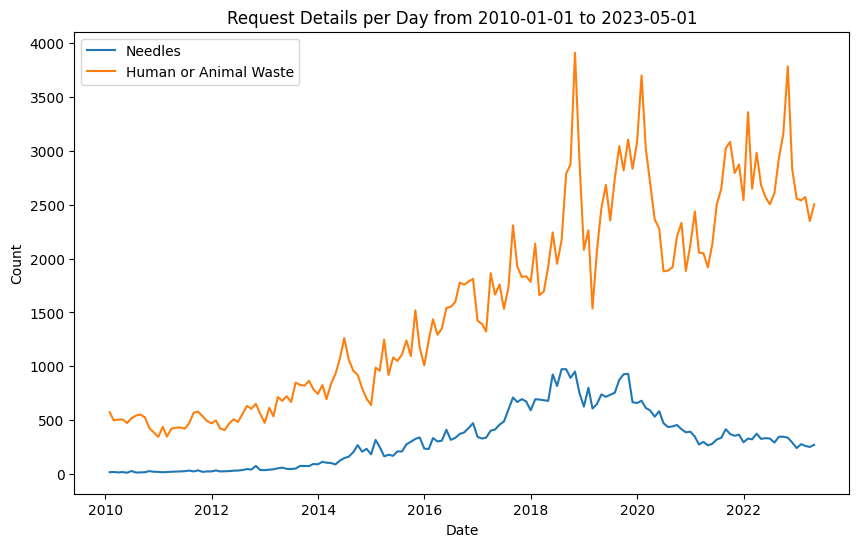

In [7]:
# Plot Needles and Human or Animal Waste
start_date = datetime.date(2010, 1, 1)
end_date = pd.to_datetime(df['Date']).dt.date.max()
categories = ['Needles', 'Human or Animal Waste']

plot_categories(df, start_date, end_date, categories)

### Plot top 10 categories

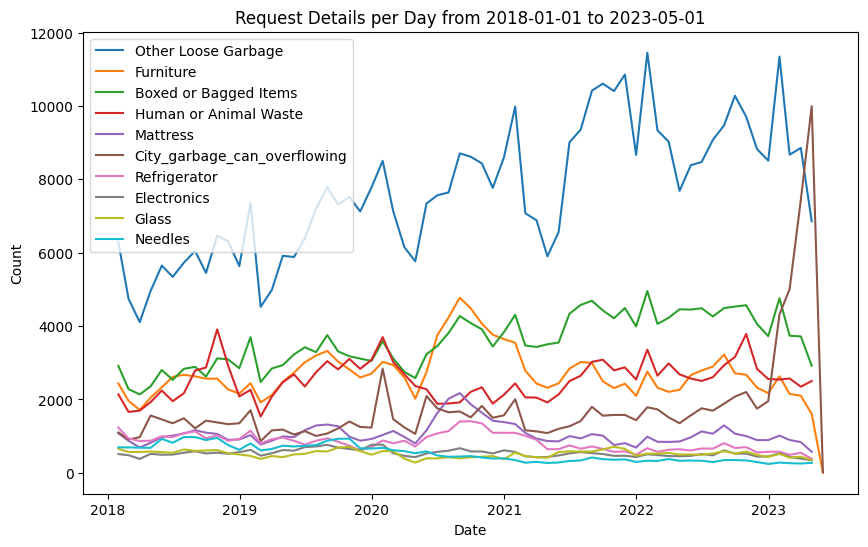

In [8]:
plot_categories(df,  datetime.date(2018, 1, 1), end_date, get_top_categories(df, top_n=10))

### Plot top 5 categories

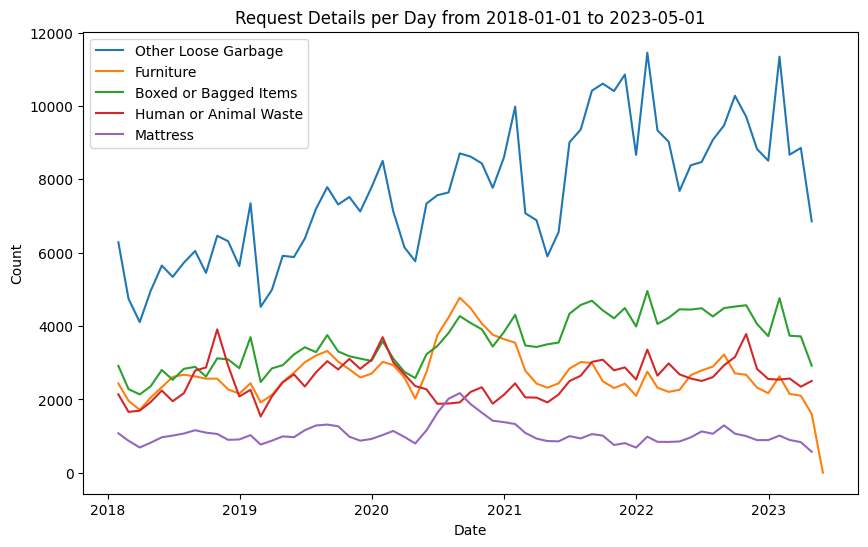

In [9]:
plot_categories(df,  datetime.date(2018, 1, 1), end_date, get_top_categories(df, top_n=5))

### Interactive plot

In [10]:
def plot_categories_interactive(df, start_date, end_date, categories, frequency='M'):
    # select rows between start and end dates
    focus_df = df[['Date', 'Request Details']].copy()
    focus_df = focus_df[(focus_df['Date'] >= start_date) & (focus_df['Date'] <= end_date)].copy()

    # create a dataframe for each category
    plot_dfs = [focus_df[focus_df['Request Details'] == cat].copy() for cat in categories]

    # convert the "Date" column to a datetime format and set it as the index for each dataframe
    for plot_df in plot_dfs:
        plot_df['Date'] = pd.to_datetime(plot_df['Date'])
        plot_df.set_index('Date', inplace=True)

    # group each dataframe by month and count the number of values in each group
    plot_dfs = [plot_df.groupby(pd.Grouper(freq=frequency)).count() for plot_df in plot_dfs]

    # Plot
    fig = go.Figure()

    for i, plot_df in enumerate(plot_dfs):
        label = categories[i]
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['Request Details'], name=label, hovertemplate='Count: %{y}<br>'))

    fig.update_layout(title=f'Request Details per Day from {start_date} to {end_date}', xaxis_title='Date', yaxis_title='Count')

    fig.show()

In [11]:
# Plot Needles and Human or Animal Waste
start_date = datetime.date(2010, 1, 1)
end_date = pd.to_datetime(df['Date']).dt.date.max()
categories = ['Needles', 'Human or Animal Waste']

plot_categories_interactive(df, start_date, end_date, categories)

### Bokeh visualization

In [12]:
def plot_categories_interactive_bokeh(df, start_date, end_date, categories, frequency='M'):
    # select rows between start and end dates
    focus_df = df[['Date', 'Request Details']].copy()
    focus_df = focus_df[(focus_df['Date'] >= start_date) & (focus_df['Date'] <= end_date)].copy()

    # create a dataframe for each category
    plot_dfs = [focus_df[focus_df['Request Details'] == cat].copy() for cat in categories]

    # convert the "Date" column to a datetime format and set it as the index for each dataframe
    for plot_df in plot_dfs:
        plot_df['Date'] = pd.to_datetime(plot_df['Date'])
        plot_df.set_index('Date', inplace=True)

    # group each dataframe by month and count the number of values in each group
    plot_dfs = [plot_df.groupby(pd.Grouper(freq=frequency)).count() for plot_df in plot_dfs]

    # create a bokeh ColumnDataSource for each dataframe
    data_sources = [ColumnDataSource(plot_df) for plot_df in plot_dfs]

    # create a bokeh figure
    p = figure(title=f"Request Details per Day from {start_date} to {end_date}", x_axis_label='Date', y_axis_label='Count',
               plot_width=1200, plot_height=700)  # set plot width and height here

    # add a line glyph for each category to the figure and a corresponding Legend item
    colors = Category10[10]
    legends = []
    for i, data_source in enumerate(data_sources):
        label = categories[i]
        color = colors[i]
        line = p.line(x='Date', y='Request Details', color=color, source=data_source, name=label)
        legends.append((label, [line]))

    # add a hover tool to display count information
    hover = HoverTool(tooltips=[('Count', '@{Request Details}')])
    p.add_tools(hover)

    # specify x-axis date format
    p.xaxis.formatter = DatetimeTickFormatter(years="%Y")

    # create a Legend object and add it to the figure
    legend = Legend(items=legends)
    p.add_layout(legend, 'right')

    # specify the interactivity of clicking on a legend item to hide/show the corresponding line
    p.legend.click_policy="hide"

    # show the plot
    output_notebook()
    show(p)

In [13]:
# Plot Needles and Human or Animal Waste
start_date = datetime.date(2010, 1, 1)
end_date = pd.to_datetime(df['Date']).dt.date.max()
categories = ['Needles', 'Human or Animal Waste']

plot_categories_interactive_bokeh(df, start_date, end_date, categories)

### Plot top 10 bokeh

In [14]:
plot_categories_interactive_bokeh(df, datetime.date(2018, 1, 1), end_date, get_top_categories(df, top_n=5))

In [15]:
plot_categories_interactive_bokeh(df, datetime.date(2010, 1, 1), end_date, get_top_categories(df, top_n=5))